In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm
from tifffile import imsave
import torchvision.transforms as T
from PIL import Image
import nibabel as nib

from monai.losses import DiceCELoss
from monai.losses import DiceLoss
from monai.losses import GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Resized
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

2024-05-15 23:58:47.374795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 23:58:47.374907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 23:58:47.547220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.4.dev2419
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 74d904f75d57570f649488075b5dd75cc45625df
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.39.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/la

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpr_6kmi9d


In [4]:
import pickle
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [5]:
with open('/kaggle/input/lung-cancer-pkl-file/Lung cancer segmentation dataset with Lung-RADS class/lung_cancer_train.pkl', 'rb') as f:
    t_data = pd.read_pickle(f)


In [6]:
with open('/kaggle/input/lung-cancer-pkl-file/Lung cancer segmentation dataset with Lung-RADS class/lung_cancer_test.pkl', 'rb') as f:
    v_data = pd.read_pickle(f)


In [ ]:
t_data

In [ ]:
v_data

In [ ]:
t_data["hu_array"][0].max()

In [ ]:
t_data["hu_array"][0].min()

In [7]:
def NormalizerHu(matrix): #Normalize our data image

    matrix = (matrix - matrix.min())/(matrix.max()- matrix.min())

    return matrix



In [8]:
norm_t_data = []
for i, j in enumerate(t_data["hu_array_old"]):
  n = NormalizerHu(t_data["hu_array_old"][i])
  norm_t_data.append(n)

norm_t_data = np.array(norm_t_data)

In [9]:
norm_v_data = []
for i, j in enumerate(v_data["hu_array_old"]):
  n = NormalizerHu(v_data["hu_array_old"][i])
  norm_v_data.append(n)

norm_v_data = np.array(norm_v_data)

Since we are going to be using the UNET-R architecture, we will need to split each 3-D image into voxels, by first splitting each image into seperate 16x16 images

Since our input is of LxWxHxC, we must deduce the height(depth) of each image

It seems that our CT scans have variable depths. This means that we need to create an algorithm that can normalize the CT scan images and image segments based on their volumes

In [10]:
t_labels = []
for i in t_data['mask']:
  t_labels.append(i)

t_labels= np.array(t_labels)


In [11]:
v_labels = []
for i in v_data['mask']:
  v_labels.append(i)

v_labels= np.array(v_labels)


In [14]:
import shutil

In [12]:
parent_dir = '/kaggle/working/'
directory = 'NII Training_Images'
t_PATH = os.path.join(parent_dir, directory) 
os.mkdir(t_PATH)

In [13]:
directory = 'NII Valid_Images'
v_PATH = os.path.join(parent_dir, directory) 
os.mkdir(v_PATH)

In [15]:
t_labels = t_labels.astype(float)
v_labels = v_labels.astype(float)

In [ ]:
#shutil.rmtree(v_PATH)
#shutil.rmtree(t_PATH)

In [16]:
k = 0
start = 0
file_pos = 0
train_dict_list = []
init = t_data["label1"][0]
for i,j in enumerate(t_data["label1"]):
  if (init != j):
     f_images = nib.Nifti2Image(norm_t_data[start:k, :, :], affine=np.eye(4))
     f_labels = nib.Nifti2Image(t_labels[start:k, :, :], affine=np.eye(4))
     if(k-start > 6):
      nib.save(f_images, os.path.join(t_PATH, 'train_image' + str(file_pos)+ '.nii.gz'))
      nib.save(f_labels, os.path.join(t_PATH, 'train_label' + str(file_pos)+ '.nii.gz'))
      file_pos = file_pos + 1
     init = j
     start = k
  else:
    k = k + 1

In [17]:
k = 0
start = 0
file_pos = 0
valid_dict_list = []
init = v_data["label1"][0]
for i,j in enumerate(v_data["label1"]):
  if (init != j ):
     f_images = nib.Nifti2Image(norm_v_data[start:k, :, :], affine=np.eye(4))
     f_labels = nib.Nifti2Image(v_labels[start:k, :, :], affine=np.eye(4))
     if(k-start > 6):
      nib.save(f_images, os.path.join(v_PATH, 'valid_image' + str(file_pos)+ '.nii.gz'))
      nib.save(f_labels, os.path.join(v_PATH, 'valid_label' + str(file_pos)+ '.nii.gz'))
      file_pos = file_pos + 1
     init = j
     start = k
  else:
    k = k + 1

In [18]:
os.listdir(v_PATH)

['valid_label3.nii.gz',
 'valid_label0.nii.gz',
 'valid_image5.nii.gz',
 'valid_label1.nii.gz',
 'valid_image3.nii.gz',
 'valid_label4.nii.gz',
 'valid_image4.nii.gz',
 'valid_label5.nii.gz',
 'valid_image1.nii.gz',
 'valid_image2.nii.gz',
 'valid_image0.nii.gz',
 'valid_label2.nii.gz']

In [18]:
valid_dict_list = []
train_dict_list =[]

In [19]:
for files in range(len(os.listdir(t_PATH))//2):
  training = {
      "image": os.path.join(t_PATH, 'train_image' + str(files)+ '.nii.gz'),
      "label":  os.path.join(t_PATH, 'train_label' + str(files)+ '.nii.gz')
  }
  train_dict_list.append(training)

In [20]:
for files in range(len(os.listdir(v_PATH))//2):
  validation = {
      "image": os.path.join(v_PATH, 'valid_image' + str(files)+ '.nii.gz'),
      "label":  os.path.join(v_PATH, 'valid_label' + str(files)+ '.nii.gz')
  }
  valid_dict_list.append(validation)

In [22]:
valid_dict_list

[{'image': '/kaggle/working/NII Valid_Images/valid_image0.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label0.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image1.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label1.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image2.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label2.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image3.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label3.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image4.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label4.nii.gz'},
 {'image': '/kaggle/working/NII Valid_Images/valid_image5.nii.gz',
  'label': '/kaggle/working/NII Valid_Images/valid_label5.nii.gz'}]

In [21]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PIL"),
       
          Resized(
           keys = ["image", "label"],
           spatial_size = (128,128,128),
           mode = "nearest"
          ),
       CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64,64,64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PIL"),
        Resized(
           keys = ["image", "label"],
           spatial_size = (128,128,128),
           mode = "nearest" 
          ),
        #ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        
       CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [22]:
train_ds = CacheDataset(
    data=train_dict_list,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)

Loading dataset: 100%|██████████| 18/18 [00:08<00:00,  2.03it/s]
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
val_ds = CacheDataset(data=valid_dict_list, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


In [ ]:
recon_image = next(iter(val_loader))

In [ ]:
recon_image['label'].unique()

In [ ]:
recon_image['image'].shape

In [ ]:
plt.figure("visualize", (8, 4))
for i in range(3):
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(recon_image['image'][0,0,:,:,i], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(recon_image['label'][0,0,:,:,i])
    plt.show()

In [143]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels= 2,
    img_size=(64,64,64),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.5,
).to(device)


torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [129]:
model.load_state_dict(torch.load(os.path.join("/kaggle/working/", "best_metric_model.pth")))

<All keys matched successfully>

In [154]:
weights = torch.tensor([0.1,0.9]).to(device)

In [155]:
loss_function = DiceCELoss(to_onehot_y= True, sigmoid = False, softmax = True)

In [146]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
shutil.copyfile("/kaggle/input/metrics_unetr_checkpoint1/pytorch/checkpoint1/1/best_metric_model.pth", os.path.join("/kaggle/working/", "best_metric_model.pth"))

In [156]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/kaggle/working/", "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 9000
eval_num = 500
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/kaggle/working/", "best_metric_model.pth")))

Training (500 / 9000 Steps) (loss=0.29187):  83%|████████▎ | 15/18 [00:14<00:06,  2.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.22547100484371185 Current Avg. Dice: 0.22547100484371185


Training (1000 / 9000 Steps) (loss=0.25871):  61%|██████    | 11/18 [00:13<00:14,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.22547100484371185 Current Avg. Dice: 0.12028929591178894


Training (1500 / 9000 Steps) (loss=0.19976):  39%|███▉      | 7/18 [00:10<00:24,  2.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.22547100484371185 Current Avg. Dice: 0.20713533461093903


Training (2000 / 9000 Steps) (loss=0.24720):  17%|█▋        | 3/18 [00:08<00:47,  3.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.22547100484371185 Current Avg. Dice: 0.1672029048204422


Training (2500 / 9000 Steps) (loss=0.30720):  94%|█████████▍| 17/18 [00:14<00:01,  1.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.22547100484371185 Current Avg. Dice: 0.204546257853508


Training (3000 / 9000 Steps) (loss=0.27624):  72%|███████▏  | 13/18 [00:12<00:10,  2.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.22547100484371185 Current Avg. Dice: 0.1701974719762802


Training (3500 / 9000 Steps) (loss=0.25261):  50%|█████     | 9/18 [00:10<00:18,  2.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.22547100484371185 Current Avg. Dice: 0.20485375821590424


Training (3693 / 9000 Steps) (loss=0.11402):  22%|██▏       | 4/18 [00:04<00:15,  1.08s/it]


KeyboardInterrupt: 

In [113]:
pip install medcam

  Preparing metadata (setup.py) ... done
  Created wheel for medcam: filename=medcam-0.1.21-py3-none-any.whl size=23191 sha256=32bdfae9d6bfabef97f44f7864e6cb247b2a21fb3f614e39c74696e8856cdb9a
  Stored in directory: /root/.cache/pip/wheels/fb/5a/1c/f04ac691163a19657feccb3904d12d68e6391a5a859749d8d5
Successfully built medcam
Note: you may need to restart the kernel to use updated packages.


In [114]:
from medcam import medcam 

In [120]:
model_cam = medcam.inject(model, output_dir="attention_maps", save_maps=True)


In [148]:
train_diceCE = epoch_loss_values
valid_metric_diceCE = metric_values

In [71]:
train_dice = epoch_loss_values
valid_metric_dice = metric_values

In [59]:
train_gen_dice = epoch_loss_values
valid_metric_gen_dice = metric_values

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")
print(metric_values)

metatensor([-17.7855, -17.3689, -17.2810,  ...,  18.2122,  18.3887,  18.5565],
       device='cuda:0')
metatensor([[  0,   9, 112, 100],
        [  0,   9, 112, 101],
        [  0,   9, 112, 102],
        [  0,  23,  90, 104],
        [  0,  25,  21,  59],
        [  0,  25,  21,  60],
        [  0,  25,  21,  61],
        [  0,  25,  21,  62],
        [  0,  26,  21,  22],
        [  0,  26,  22,  18],
        [  0,  26,  22,  19],
        [  0,  26,  22,  20],
        [  0,  26,  22,  21],
        [  0,  26,  22,  22],
        [  0,  26,  22,  23],
        [  0,  26,  22,  24],
        [  0,  26,  22,  25],
        [  0,  26,  22,  26],
        [  0,  26,  22,  27],
        [  0,  28,   7,  39],
        [  0,  28,   7,  78],
        [  0,  28,   7,  79],
        [  0,  28,   7,  80],
        [  0,  28,  12,  27],
        [  0,  28,  12,  28],
        [  0,  28,  12,  29],
        [  0,  28,  12,  30],
        [  0,  28,  12,  31],
        [  0,  28,  13,  28],
        [  0,  28,  13,

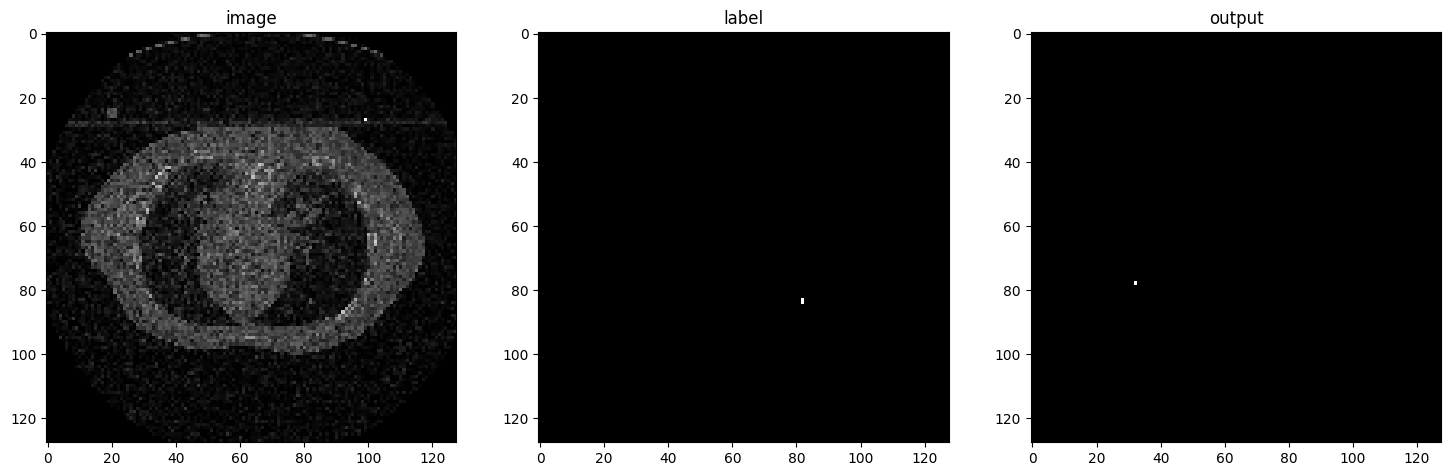

In [157]:

case_num = 0

model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    

    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    
    
    val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.25)
    
    print(val_outputs.unique())
    print((torch.argmax(val_outputs, dim=1) == 1).nonzero(as_tuple=False))
    print((val_labels == 1).nonzero(as_tuple=False))
    
    
    
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 69], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 69], cmap="gray")
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu().cpu().numpy()[0,:,:,69], cmap = "gray")
    plt.show()

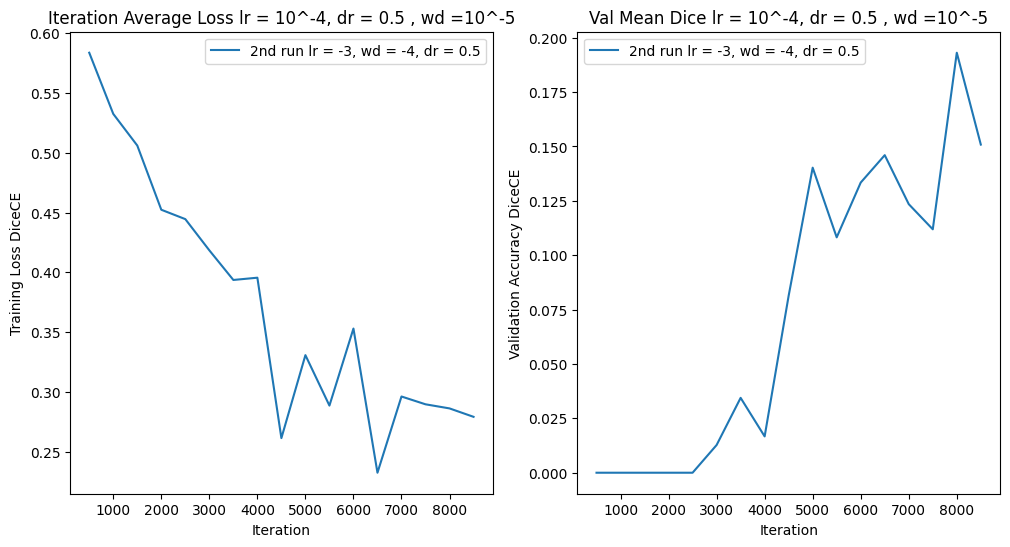

In [149]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss lr = 10^-4, dr = 0.5 , wd =10^-5")
x = [eval_num * (i + 1) for i in range(len(train_diceCE))]
y = train_diceCE
plt.xlabel("Iteration")
plt.ylabel("Training Loss DiceCE")
plt.plot(x, y, label = "2nd run lr = -3, wd = -4, dr = 0.5")
#x = [eval_num * (i + 1) for i in range(len(train_dice))]
#y = train_dice
#plt.plot(x, y, label = "3rd run lr = -2, wd = -4, dr = 0.5")
#x = [eval_num * (i + 1) for i in range(len(train_gen_dice))]
#y = train_gen_dice
#plt.plot(x, y, label = "Dropout 0.5")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice lr = 10^-4, dr = 0.5 , wd =10^-5")
x = [eval_num * (i + 1) for i in range(len(valid_metric_diceCE))]
y = valid_metric_diceCE
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy DiceCE")
plt.plot(x, y, label = "2nd run lr = -3, wd = -4, dr = 0.5")
#x = [eval_num * (i + 1) for i in range(len(valid_metric_dice))]
#y = valid_metric_dice
#plt.plot(x, y, label = "3rd run lr = -2, wd = -4, dr = 0.5")
#x = [eval_num * (i + 1) for i in range(len(valid_metric_gen_dice))]
#y = valid_metric_gen_dice
#plt.plot(x, y, label = "Genralized Dice Loss")
plt.legend()

plt.show()